In [25]:
from qiskit import *
import numpy as np
#import mathplotlib.plyplot as plt
%matplotlib inline

from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram

from math import pi, sqrt

In [2]:
IBMQ.load_accounts()

In [33]:
def execute_circ(circ, shots):
    backend = Aer.get_backend('qasm_simulator')
    job = execute(circ, backend=backend, shots=shots)
    #job_monitor(job)
    result = job.result()
    answer = result.get_counts()
    #print(plot_histogram(answer))
    
    return answer

In [4]:
def evaluate_prob(answer,shots):
    
    answer_prob = [[0,0], [0,0]]
    
    for state, freq in answer.items():
        system = int(state[1])
        pointer= int(state[0])
        answer_prob[system][pointer] += freq/shots
        
        
    return answer_prob

# Create circuit for evaluating <<M^2_out>>
Following (Eq.20) and its description, I measure the pointer in the Hadamard basis as M=X. The result is divided into two parts conditional upon the presence of 2 post-selection states 

In [24]:
def circuit_Mout(pointer_u3_theta):
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    circ = QuantumCircuit(qr,cr)
    
    # Initialize system and pointer states
    circ.u3(pi/2, pi/2, 0, qr[0])
    circ.u3(pointer_u3_theta, 0, 0, qr[1])
    
    # Apply inverted CNOT gate
    circ.cx(qr[0], qr[1])
    
    # Measure pointer in M = Pauli X
    circ.h(qr[1])
    circ.measure(qr[1],cr[1])
    circ.barrier()
    
    # Measure system in B = Pauli Z
    circ.measure(qr[0],cr[0])
    
    return circ

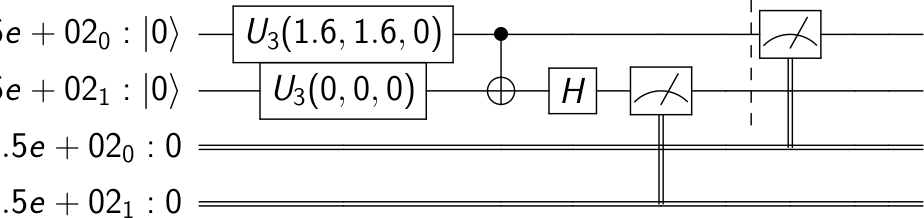

In [53]:
theta = 0
circ = circuit_Mout(theta)
circ.draw(output='latex')

In [28]:
def calculate_Mout(pointer_u3_theta):
    circ = circuit_Mout(pointer_u3_theta)
    
    shots = 2000
    answer = execute_circ(circ,shots)
    answer_prob = evaluate_prob(answer,shots)
    
    pointer_states = {0: 1,
                     1: -1}
    # M_out_squared for 2 postselection options
    M2_out = [0,0]
    M2_out[0] = sum(eigenvalue**2 * answer_prob[0][state] for state,eigenvalue in pointer_states.items())
    M2_out[1] = sum(eigenvalue**2 * answer_prob[1][state] for state,eigenvalue in pointer_states.items())    

    return M2_out
    

# Create circuit for evaluating <<A^2_in>>
Following (Eq.21) and its description, A=X has two eigenvalues a = +1 and -1 corresponding to eigenstates |a⟩ =  |+⟩ and |-⟩ respectively. The expectation value ⟨A⟩ = ⟨psi|a⟩ * ⟨a|psi⟩ = Probability of outcome |a⟩ when the system is initialized in |psi⟩.

For those reasons, the system qubit is rotated into Hadamard basis before measurement.

In [7]:
def circuit_Ain(pointer_u3_theta):
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    circ = QuantumCircuit(qr,cr)
    
    # Initialize system and pointer states
    circ.u3(pi/2, pi/2, 0, qr[0])
    circ.u3(pointer_u3_theta, 0, 0, qr[1])
    
    # Measure system in A = Pauli X
    circ.h(qr[0])
    circ.measure(qr,cr)
    
    return circ

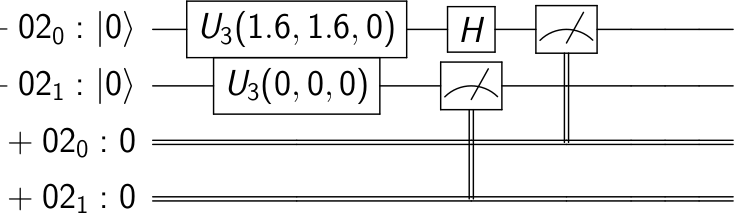

In [52]:
theta = 0
circ = circuit_Ain(theta)
circ.draw(output='latex')

In [27]:
def calculate_Ain(pointer_u3_theta):
    circ = circuit_Ain(pointer_u3_theta)
    
    shots = 2000
    answer = execute_circ(circ, shots)
    answer_prob = evaluate_prob(answer, shots)
    
    system_states = {0: 1,
                    1: -1}
    # A_in_squared
    A2_in = sum(eigenvalue**2 * (sum(prob for prob in answer_prob[state])) for state,eigenvalue in system_states.items())
    return A2_in

# Create circuit for evaluating − <<M_out A_in + A_in M_out>>
Following (Eq.22) and its description, I create three distinct circuits to evaluate every term, then multiply the expectation values with regarding eigenvalues m of M=X

In [9]:
def circuit_lastpart(op, pointer_u3_theta):
    qr = QuantumRegister(4)
    cr = ClassicalRegister(4)
    circ = QuantumCircuit(qr,cr)
    
    # Initialize system and pointer states
    circ.u3(pi/2, pi/2, 0, qr[0])
    circ.u3(pointer_u3_theta, 0, 0, qr[1])
    
    # Three-state method applied
    if (op == 1):
        # A\psi = X\psi
        circ.x(qr[0])
    if (op == 2):
        circ.u2(0,0,qr[0])

        circ.x(qr[0])
        circ.cx(qr[0],qr[2])
        circ.measure(qr[2],cr[2])
        circ.barrier(qr)
        circ.x(qr[0])
        circ.cz(qr[0],qr[3])
        circ.measure(qr[3],cr[3])
        circ.barrier(qr)

        circ.u2(pi,pi,qr[0])
    

    # Apply inverted CNOT gate
    circ.cx(qr[0], qr[1])
    
    # Measure pointer in M = Pauli X
    circ.h(qr[1])
    circ.measure(qr[1],cr[1])
    circ.barrier()
    
    # Measure system in B = Pauli Z
    circ.measure(qr[0],cr[0])
    
    return circ

In [10]:
def calculate_lastpart(pointer_u3_theta):
    shots = 2000
    
    pointer_states = {0: 1,
                      1: -1}
    
    # lastpart for 2 postselection options of each term
    lastpart_terms = [[0,0], [0,0], [0,0]]
    
    for op in range(3):
        circ = circuit_lastpart(op,pointer_u3_theta)
        answer = execute_circ(circ,shots)
        answer_prob = evaluate_prob(answer, shots)
        lastpart_terms[op][0] = sum(eigenvalue * answer_prob[0][state] for state,eigenvalue in pointer_states.items())
        lastpart_terms[op][1] = sum(eigenvalue * answer_prob[1][state] for state,eigenvalue in pointer_states.items())
        
    lastpart = [0,0]    
    lastpart[0] = lastpart_terms[0][0] + lastpart_terms[1][0] - lastpart_terms[2][0]
    lastpart[1] = lastpart_terms[0][1] + lastpart_terms[1][1] - lastpart_terms[2][1]
    
    return lastpart

In [48]:
for i in range(6):
    theta = pi*i/10
    print(calculate_Mout(theta))
    print(calculate_Ain(theta))
    print(calculate_lastpart(theta))
    print("\n")

C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  config = original_config.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:54: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  return obj.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  config = original_config.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:54: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  return obj.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The

[0.494, 0.506]
1.0
[1.5070000000000001, -0.507]


[0.486, 0.514]


C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  config = original_config.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:54: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  return obj.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  config = original_config.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:54: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  return obj.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The

1.0
[1.5114999999999998, -0.5115]


[0.5045000000000001, 0.49550000000000005]


C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  config = original_config.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:54: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  return obj.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  config = original_config.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:54: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  return obj.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The

1.0
[1.5175, -0.5175000000000001]


[0.516, 0.484]


C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  config = original_config.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:54: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  return obj.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  config = original_config.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:54: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  return obj.as_dict()


1.0


C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  config = original_config.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:54: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  return obj.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  config = original_config.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:54: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  return obj.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The

[1.5055, -0.5055]


[0.504, 0.496]
1.0


C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  config = original_config.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:54: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  return obj.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  config = original_config.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:54: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  return obj.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The

[1.4969999999999999, -0.497]


[0.51, 0.49]
1.0
[1.482, -0.482]




C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:54: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  return obj.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:119: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  config = original_config.as_dict()
C:\Users\trongduong\AppData\Roaming\Python\Python36\site-packages\qiskit\providers\aer\backends\aerbackend.py:54: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  return obj.as_dict()
